In [96]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [97]:
class VehicleAgent(Agent):

    def __init__(self, unique_id, model, initialLane,fullyFunctional):
        super().__init__(unique_id, model)
        self.speed = 3
        self.lane = initialLane
        self.functional = fullyFunctional
        self.changedLane = False

    # 0 es x // 1 es y
    def getFrontEmptySpaces(self):
        # Get front empty spaces
        frontEmptySpaces = 0
        for i in range(1,4):
            #Check if it´s inside the grid and empty
            if self.pos[1]+i <= self.model.grid.height-1 and self.model.grid.is_cell_empty((self.pos[0],self.pos[1]+i)):
                #Add 1 to empty space
                frontEmptySpaces += 1
            else:
                break
        return frontEmptySpaces

    def getFrontVehicle(self):
        # Get front vehicle
        frontVehicle = None
        for i in range(1,4):
            if self.pos[1]+i <= self.model.grid.height-1 and not self.model.grid.is_cell_empty((self.pos[0],self.pos[1]+i)):
                frontVehicle = self.model.grid.get_cell_list_contents([(self.pos[0],self.pos[1]+i)])[0]
                break
        return frontVehicle

    def whereToChange(self):
        # Check if there is a vehicle in the next lane
        rightLane = ()
        leftlane = ()
        if self.model.grid.is_cell_empty((self.pos[0]+1, self.pos[1])):
            rightLane = (self.pos[0]+1, self.pos[1])
        elif self.model.grid.is_cell_empty((self.pos[0]-1, self.pos[1])):
            leftlane = (self.pos[0]-1, self.pos[1])
        # If right lane is empty, change to right lane
        if rightLane:
            return rightLane
        # If left lane is empty, change to left lane
        elif leftlane:
            return leftlane
        # If there is no empty lane, stay in the same lane
        else:
            return self.pos

    def changeLane(self,laneToChange):
        # Change lane
        self.model.grid.move_agent(self,laneToChange)
        self.lane = laneToChange[0]
        #Move again
        self.step()

    def returnToLane(self):
        # Return to lane
        self.model.grid.move_agent(self,(1,self.pos[1]))
        self.changedLane = False
        #Move again
        self.step()
        
    def step(self):
        if self.model.hasStopped and self.lane == 1 and self.pos[1] == 0:
            laneToChange = self.whereToChange()
            self.changeLane(laneToChange)
            self.changedLane = True
        if  self.functional==0 and self.pos[1] == 90:
            self.speed = 0
            self.model.hasStopped = True
        # Get front empty spaces
        frontEmptySpaces = self.getFrontEmptySpaces()
        # Get front vehicle
        frontVehicle = self.getFrontVehicle()

        
        #print("Iniciando el step del auto:", self.unique_id)
        if self.changedLane== True and self.pos[1] > 90:
            # Return to lane
            self.returnToLane()
        if frontVehicle is not None:

            #Modificar las velocidades de los vehiculos-----------------------------------------
            #1 o 2 espacios disponibles en la linea central
            if frontEmptySpaces == 2 or frontEmptySpaces == 1:
                #Velocidad del vehiculo de enfrente es inferior a la actual
                if self.lane == 1 and frontVehicle.speed != self.speed:
                    #Ver a que linea cambiarse
                    laneToChange = self.whereToChange()
                    #Si se puede cambiar cambiarse 
                    if laneToChange != self.pos:
                        self.changeLane(laneToChange)
                        self.changedLane = True
                    #Caso contrario reducir la velocidad para poder esperar
                    else:
                        self.speed = 1
                #Si no esta en el carril central que tome la velocidad del auto de adelante
                elif self.lane == 2 or self.lane == 3:
                    self.speed = frontVehicle.speed
            #0 espacios disponibles en la linea central
            if frontEmptySpaces == 0:
                if self.lane == 1 and frontVehicle.speed != self.speed:
                    laneToChange = self.whereToChange()
                    if laneToChange != self.pos:
                        self.changeLane(laneToChange)
                    #Si no se puede cambiar cambiar velocidad a 0 (detener el vehiculo)
                    else:
                        self.speed = 0
                #Si no esta en el carril central que tome la velocidad del auto de adelante
                elif self.lane == 2 or self.lane == 3:
                    self.speed = frontVehicle.speed

            #Move agent / Stop the chosen agent-----------------------------------------
            #Check if space to move is out of bounds
                if self.pos[1]+self.speed >= self.model.grid.height-1:
                    #Eliminar agente si este se sale del grid
                    self.model.grid.remove_agent(self)
                    self.model.schedule.remove(self)
                else:
                    if self.functional == 1:
                        #Si se queda dentro del grid, moverse
                        self.model.grid.move_agent(self,(self.pos[0], self.pos[1]+self.speed))
                    else:
                        #Detenerse a la mitad del grid
                        if self.pos[1] < 90:
                            self.model.grid.move_agent(self,(self.pos[0], self.pos[1]+self.speed))
                        else:
                            self.speed = 0

        else:
            #Move agent / Stop the chosen agent-----------------------------------------
            #Check if space to move is out of bounds
            if self.pos[1]+self.speed >= self.model.grid.height-1:
                #Eliminar agente si este se sale del grid
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
            else:
                # if self.functional == 1:
                    #Si se queda dentro del grid, moverse
                self.model.grid.move_agent(self,(self.pos[0],self.pos[1]+self.speed))
                # else:
                #     #Detenerse a la mitad del grid
                #         if self.pos[1] < 90:
                #             self.model.grid.move_agent(self,(self.pos[0], self.pos[1]+self.speed))
                #         else:
                #             self.speed = 0

In [98]:
def getGrid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if model.grid.is_cell_empty((x,y)):
            grid[x][y] = 0
        else:
            if content.functional == 1:
                grid[x][y] = 0.2
            else:
                grid[x][y] = 1 #Auto descompuesto
    return grid

In [99]:
class HighwayModel(Model):

    def __init__(self,width,height):
        self.movimientos = 0
        self.numAgentsCreated = 0
        self.grid = SingleGrid(width,height,False)
        self.schedule = BaseScheduler(self)
        self.datacollector = DataCollector(model_reporters={"Grid":getGrid})
        self.hasStopped = False

    #El agente que se para es el 120, tarda 30 movimientos en llegar a la mitad del grid
    # de esta forma este se para en el segundo 150 (la mitad de la simulación)

    def step(self):
        initialRail = np.random.choice([0,1,2])
        if self.numAgentsCreated != 120:
            car = VehicleAgent(self.numAgentsCreated,self,initialRail,1)
            self.grid.place_agent( car,(initialRail,0) )
            self.schedule.add(car)
            self.numAgentsCreated += 1 
        else: 
            car = VehicleAgent(self.numAgentsCreated,self,1,0)
            self.grid.place_agent( car,(1,0) )
            self.schedule.add(car)
            self.numAgentsCreated += 1 
        self.datacollector.collect(self)
        self.schedule.step()
        self.movimientos += 1

In [100]:
MAX_ITER = 300
WIDTH = 3
HEIGHT = 183

start_time = time.time()

model = HighwayModel(WIDTH,HEIGHT)

for i in range(MAX_ITER):
    model.step()

print("Tiempo de ejecución: ", str(datetime.timedelta(seconds=(time.time()-start_time))))

Tiempo de ejecución:  0:00:00.203864


In [101]:
all_grid = model.datacollector.get_model_vars_dataframe()
#print(all_grid)

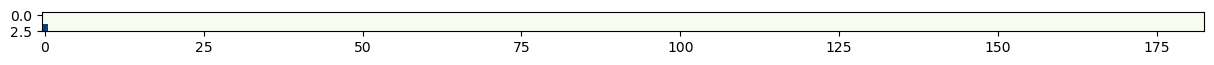

In [102]:
fig, axs = plt.subplots(figsize=(15,15))
axs.set_xticks = ([])
axs.set_yticks = ([])
patch = plt.imshow(all_grid.iloc[0][0], cmap='GnBu')

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig,animate,frames=MAX_ITER)

In [103]:
anim

KeyboardInterrupt: 